# Notebook to create optimal statistic plot

### Download data and uncompress the files into this folder

https://drive.google.com/file/d/1zywc5zUpMSlYDrrdogPEaRd_RTr9U5J6/view?usp=sharing

In [ ]:
!pip install tqdm

In [1]:
import json
import glob
import numpy as np
import scipy.stats as scistats

from optimal_statistic_covariances import OS, full_lstsq_recovery
from enterprise_extensions.models import model_2a
import matplotlib.pyplot as plt
import matplotlib

from h5pulsar.pulsar import FilePulsar

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

### Plotting options

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
with open('../ng15_rcparams.json', 'rb') as fin:
    plt.rcParams.update(json.load(fin))
plt.rcParams['text.latex.preamble'] = (
    r'\usepackage{amsmath}'
    r'\usepackage{amsbsy}'
    r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'
)

# Preliminaries

In [3]:
datapath = './figure1_data/'
pulsar_datapath = '../../tutorials/data/'

In [4]:
# Hellings-Downs curve
def hd(angseps):
    xx = 0.5 * (1-np.cos(angseps))
    return 1.5*xx*np.log(xx) - 0.25*xx + 0.5

In [5]:
psrs = []
for hdf5_file in glob.glob(pulsar_datapath + '/hdf5/*.hdf5'):
    psrs.append(FilePulsar(hdf5_file))
print('Loaded {0} pulsars from hdf5 files'.format(len(psrs)))

Loaded 67 pulsars from hdf5 files


In [6]:
noise_dict_file = datapath + 'v1p1_wn_dict.json'
noise_dictionary = json.load(open(noise_dict_file, 'r'))

In [7]:
pta = model_2a(psrs, noisedict=noise_dictionary, tm_marg=False, 
               psd='powerlaw', n_rnfreqs=30, n_gwbfreqs=14, gamma_common=13.0/3.0)

# New OS

In [8]:
ml_os_vector = json.load(open(datapath + 'optstat_ml_gamma4p33.json', 'r'))

In [9]:
os_obj = OS(psrs, pta, ml_os_vector)

In [10]:
print(f"A^2 estimate: {os_obj.os()} +/- {os_obj.os_sigma()} with SNR: {os_obj.snr()}")

A^2 estimate: 6.703650273305144e-30 +/- 1.2324322072882867e-30 with SNR: 5.439366347018102


In [11]:
## takes ~18 minutes on my laptop. 
## matrix is symmetric so divide expected 
## remaining time by 2 when looking at progress bar.

#covariance_matix_between_rhos = os_obj.gw_corr()
covariance_matix_between_rhos = np.load(datapath + 'os_covariance_matix_between_rhos.npy')

In [12]:
covariance_matix_between_rhos

array([[ 5.22836173e-57,  3.31890773e-59, -8.19314596e-60, ...,
         2.96376121e-63,  2.05278837e-63,  1.10808595e-62],
       [ 3.31890773e-59,  8.78766355e-57, -2.38145981e-59, ...,
        -9.96874920e-62, -5.42093186e-62, -7.67437158e-63],
       [-8.19314596e-60, -2.38145981e-59,  5.50608497e-58, ...,
        -3.52642338e-61, -2.19418135e-61, -3.18671294e-61],
       ...,
       [ 2.96376121e-63, -9.96874920e-62, -3.52642338e-61, ...,
         7.63763010e-59,  2.09878740e-59,  2.29977449e-60],
       [ 2.05278837e-63, -5.42093186e-62, -2.19418135e-61, ...,
         2.09878740e-59,  8.73747903e-58,  1.78970758e-59],
       [ 1.10808595e-62, -7.67437158e-63, -3.18671294e-61, ...,
         2.29977449e-60,  1.78970758e-59,  1.36070194e-58]])

In [13]:
a_hat, a_covariance = full_lstsq_recovery(os_obj, covariance_matix_between_rhos)

In [14]:
print(f"A^2 estimate: {a_hat} +/- {a_covariance} with SNR: {np.round(a_hat / a_covariance, 2)}")

A^2 estimate: 4.209297591762329e-28 +/- 1.1178313327534165e-30 with SNR: 376.56


In [15]:
Crho = covariance_matix_between_rhos.copy()

## Binned statistic (assumes independent pairs)

Pair-covariant binning performed later using equations from Allen & Romano (2023)

In [16]:
# compute weighted average of correlation data
def weightedavg(rho, sig):
    weights, avg = 0., 0.
    for r,s in zip(rho,sig):
        weights += 1./(s*s)
        avg += r/(s*s)
        
    return avg/weights, np.sqrt(1./weights)

### Divide by CURN amplitude

In [17]:
A2_curn = 10**(2*ml_os_vector['gw_log10_A'])

In [18]:
normalizing_amp = A2_curn

### Different bin numbers -- equal-ish number of pairs

In [23]:
xii_bins = np.array([  0.95374012,  19.17571344,  27.97758157,  36.88462878,
                     44.45930411,  49.2       ,  61.21951091,  71.13671451,
                     81.52651267,  91.76848602, 102.58676647, 113.15847004,
                     125.06124956, 139.03110153, 152.7987445 , 178.7581949 ])*np.pi/180.0

nbins_cdf = len(xii_bins) # TODO: check if this is correct

147
143
151
152
73
208
158
146
147


Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.50000000000006]), which exceeds Locator.MAXTICKS (1000).


152
139
153
148
147
145


Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.50000000000006]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.50000000000006]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.50000000000006]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.50000000000006]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.50000000000006]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.50000000000006]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.50000000000006]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8233 ticks ([-124.10000000000001, ..., 287.500000000

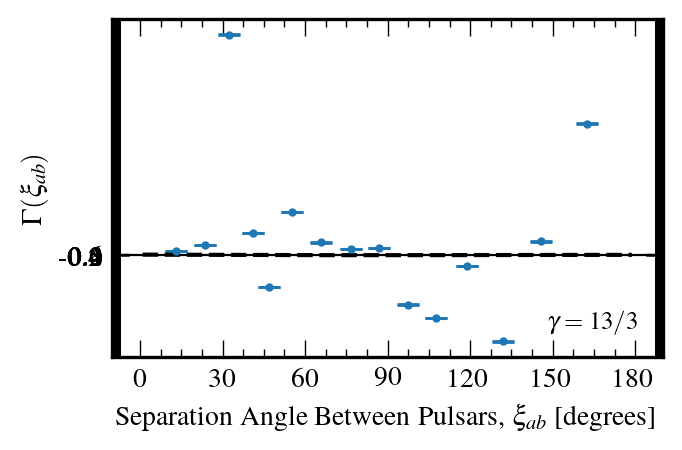

In [24]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(1, 1, sharex=True, rasterized=True)
    
### 
xii, rho, sig, hd_coeffs = os_obj.angles, os_obj.rhos, os_obj.sigmas, os_obj.orfs

bins = xii_bins 
bin_inds = np.digitize(xii,bins)-1

xii_mean = []
xii_err = []

## uncorrelated pairs
rho_avg = []
sig_avg = []

## correlated pairs
rho_avg_corr = []
sig_avg_corr = []

npairs = []
for ii in range(15):
    
    mask = bin_inds == ii
    npairs.append(np.sum(mask))
    print(np.sum(mask))

    xii_mean.append(np.mean(xii[mask]))
    xii_err.append(np.std(xii[mask]))

    r, s = weightedavg(rho[mask], sig[mask])
    rho_avg.append(r)
    sig_avg.append(s)
    
    ubin = os_obj.orfs[mask] 
    rho_tmp = rho[mask] 
    hd_fac = hd(xii_mean[ii]) 
    
    # computing binned estimator using Allen & Romano (2023)
    Cbin = Crho[mask,:][:,mask] 
    Xmat = (ubin.T @ np.linalg.inv(Cbin) @ ubin)**(-1.0)
    rho_avg_corr.append( hd_fac * Xmat * (ubin.T @ np.linalg.inv(Cbin) @ 
                                 rho_tmp) )
    sig_avg_corr.append( np.abs(hd_fac) * Xmat**0.5 )

    
xii_mean = np.array(xii_mean)
xii_err = np.array(xii_err)

(_, caps, _) = axs.errorbar(180/np.pi*xii_mean,
                            np.array(rho_avg_corr)/normalizing_amp, 
                            yerr=np.array(sig_avg_corr)/normalizing_amp, 
                            ls='', color='C0',
                            fmt='.', capsize=4, elinewidth=1.2, 
                            alpha=1.0, label='$\gamma=13/3$')

axs.axhline(0, color='k', lw=0.8)

### over-plot the HD curve 
idx = np.argsort(xii)
axs.plot(180/np.pi*xii[idx], hd_coeffs[idx], 
         lw=1.5, color='k', ls='dashed')
axs.set_ylabel(r'$\Gamma(\xi_{ab})$')
#axs.set_ylabel(r'Correlation Between Pulsars');
#axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'));

### aesthetics
plt.xticks([0, 30, 60, 90, 120, 150, 180])
plt.yticks([-0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8], 
           ['-0.4', '-0.2', '0.0', '0.2', '0.4', '0.6', '0.8'])
plt.xlim(-10.01,190.01)
# plt.ylim(1.05*np.array(rho_avg_corr).min()/1e-30,1.05*np.array(rho_avg_corr).max()/1e-30)
plt.xlabel(r'Separation Angle Between Pulsars, $\xi_{ab}$ [degrees]',fontsize=10)

empty_patch = mpatches.Patch(color='none', 
                             label='$\gamma=13/3$') 
plt.legend(handles=[empty_patch],loc='lower right',
           frameon=False,prop={'size': 9})

plt.show()
#plt.savefig('./nano15_14f_fg_oscrosscor_paircorr_fig1_061123.pdf',bbox_inches='tight',dpi=400)

In [21]:
binned_estimator_cov = np.zeros((nbins_cdf,nbins_cdf))
for ii in range(nbins_cdf):
    for jj in range(nbins_cdf):
        
        mask_ii = bin_inds == ii
        mask_jj = bin_inds == jj
        
        ubin_ii = os_obj.orfs[mask_ii] 
        ubin_jj = os_obj.orfs[mask_jj] 
        
        hd_ii = hd(np.mean(xii[mask_ii]))
        hd_jj = hd(np.mean(xii[mask_jj]))
        
        Cbin_ii = Crho[mask_ii,:][:,mask_ii]
        Cbin_jj = Crho[mask_jj,:][:,mask_jj]
        Cbin_ij = Crho[mask_ii,:][:,mask_jj]
        top = ubin_ii.T @ np.linalg.inv(Cbin_ii) @ Cbin_ij @ np.linalg.inv(Cbin_jj) @ ubin_jj
        bot = (ubin_ii.T @ np.linalg.inv(Cbin_ii) @ ubin_ii) * (ubin_jj.T @ np.linalg.inv(Cbin_jj) @ ubin_jj)
        binned_estimator_cov[ii,jj] = hd_ii * hd_jj * top / bot

In [22]:
# pair-correlated OS

binned_chi2_paircorr = (np.array(rho_avg_corr) - A2_curn*hd(xii_mean)).T @ np.linalg.inv(binned_estimator_cov) @ (np.array(rho_avg_corr) - A2_curn*hd(xii_mean))
print(binned_chi2_paircorr)

####
dof = np.array(rho_avg_corr).shape[0] #- 1
pval_paircorr = scistats.chi2(df=dof).sf(x=binned_chi2_paircorr)
print(pval_paircorr)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 15)